# Visualization of Stock Trading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import datetime
import pandas_datareader.data as web


import matplotlib.pyplot as plt

import logging
import coloredlogs

from train import *
from evaluate import show_eval_result

# Altair:
# in case of error on notebook: Istll vega_datasets
#conda install -c conda-forge altair vega_datasets notebook vega
#see also https://altair-viz.github.io/getting_started/installation.html
alt.renderers.enable('notebook')

Using TensorFlow backend.


[[0.5        0.5        0.5        0.5        0.00247262 0.99330715]]
(1, 6)


RendererRegistry.enable('notebook')

## Set relevant parameters
 - Window-Size: cutout of stock data that agent gets as state for his decision making
 - ep_count: # of epochs
 - Model Name (hint: model saved automatically after 10 epochs)
 - Pretrained: Load Pretrained Model or create new one

In [43]:
window_size = 15
batch_size = 20 #16
ep_count = 30 # 3-5 for debugging, otherwise 20-100
model_name = 'model_w15v2'
pretrained = False
debug = False

## Load Datasets into pandas DataFrame

I1003 18:16:27.698170  8916 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-03 18:16:27 PC-Stefan urllib3.connectionpool[18304] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I1003 18:16:28.083768  8916 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-03 18:16:28 PC-Stefan urllib3.connectionpool[18304] DEBUG https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I1003 18:16:28.447201  8916 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1325386800&period2=1514861999&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-03 18:16:28 PC-Stefan urllib3.connectionpool[18304] DEBUG https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1325386800&perio

<Figure size 432x288 with 0 Axes>

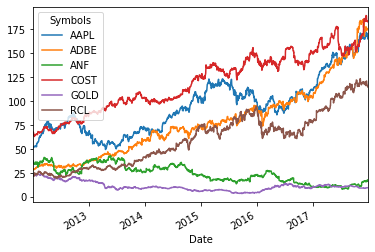

In [33]:
# Loading Train Data
# Setting Start and Enddate for Validation

start_train= datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2018, 1, 1)
start_val = end_train
end_val = datetime.datetime.now()


# Load Test Data

# Load several stocks
df_train = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_train, end=end_train)['Adj Close']

df2_train = web.DataReader('GOLD','yahoo',
                               start=start_train, #start_train
                               end=end_train) #end_train


df_val = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_val, #start_train
                               end=end_val)['Adj Close'] #end_val
df2_val = web.DataReader('GOLD','yahoo',
                               start=start_val, #start_val
                               end=end_val)  #end_val


# Convert df2_test to list
df2_train_list = list(df2_train['Adj Close'])
df2_val_list = list(df2_val['Adj Close'])

plt.figure();
df_train.plot();

## Training of Model
 - List of stocks (loaded above) is shuffled in every epoch

I1003 21:41:46.634913  8916 train.py:156] switching to TensorFlow for CPU
2019-10-03 21:41:46 PC-Stefan root[18304] DEBUG switching to TensorFlow for CPU


Symbols          GOLD        ANF       ADBE       COST       AAPL        RCL
Date                                                                        
2012-01-03  28.570000  22.927416  51.269413  22.028625  37.513138  67.481003
2012-01-04  28.280001  23.270050  51.544937  22.215746  36.262455  67.058258
2012-01-05  28.480000  23.173536  52.117188  22.113682  35.211254  66.412148
2012-01-06  28.719999  22.941902  52.662014  21.688419  34.459309  64.713181
2012-01-09  28.530001  23.023935  52.578468  21.756460  35.011761  63.022152


Episode 1/30: 100%|██████████| 1508/1508 [00:25<00:00, 59.96it/s]
I1003 21:42:12.059944  8916 train.py:147] Episode 1/30 - Train Position: +$134.92  Val Position: +$18.13  Train Loss: 0.0828  (~25.1500 secs)
2019-10-03 21:42:12 PC-Stefan root[18304] INFO Episode 1/30 - Train Position: +$134.92  Val Position: +$18.13  Train Loss: 0.0828  (~25.1500 secs)
Episode 1/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.89it/s]
I1003 21:42:36.604889  8916 train.py:144] Episode 1/30 - Train Position: +$27.43  Val Position: USELESS  Train Loss: 0.0449  (~24.3674 secs)
2019-10-03 21:42:36 PC-Stefan root[18304] INFO Episode 1/30 - Train Position: +$27.43  Val Position: USELESS  Train Loss: 0.0449  (~24.3674 secs)
Episode 1/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.26it/s]
I1003 21:43:01.004733  8916 train.py:147] Episode 1/30 - Train Position: -$7.89  Val Position: +$36.96  Train Loss: 0.0204  (~24.2233 secs)
2019-10-03 21:43:01 PC-Stefan root[18304] INFO Episode 1/30 - Train Position: -$7.89  

Symbols          COST       GOLD       AAPL        ANF        RCL       ADBE
Date                                                                        
2012-01-03  28.570000  67.481003  22.028625  22.927416  37.513138  51.269413
2012-01-04  28.280001  67.058258  22.215746  23.270050  36.262455  51.544937
2012-01-05  28.480000  66.412148  22.113682  23.173536  35.211254  52.117188
2012-01-06  28.719999  64.713181  21.688419  22.941902  34.459309  52.662014
2012-01-09  28.530001  63.022152  21.756460  23.023935  35.011761  52.578468


Episode 2/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.98it/s]
I1003 21:44:38.770163  8916 train.py:147] Episode 2/30 - Train Position: +$78.41  Val Position: +$63.44  Train Loss: 0.0698  (~24.3315 secs)
2019-10-03 21:44:38 PC-Stefan root[18304] INFO Episode 2/30 - Train Position: +$78.41  Val Position: +$63.44  Train Loss: 0.0698  (~24.3315 secs)
Episode 2/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.75it/s]
I1003 21:45:03.375172  8916 train.py:147] Episode 2/30 - Train Position: +$152.14  Val Position: +$47.72  Train Loss: 0.0499  (~24.4226 secs)
2019-10-03 21:45:03 PC-Stefan root[18304] INFO Episode 2/30 - Train Position: +$152.14  Val Position: +$47.72  Train Loss: 0.0499  (~24.4226 secs)
Episode 2/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.11it/s]
I1003 21:45:27.834789  8916 train.py:147] Episode 2/30 - Train Position: -$29.15  Val Position: +$1.05  Train Loss: 0.0391  (~24.2755 secs)
2019-10-03 21:45:27 PC-Stefan root[18304] INFO Episode 2/30 - Train Position: -$29.15 

Symbols           RCL       AAPL       GOLD       COST       ADBE        ANF
Date                                                                        
2012-01-03  22.927416  37.513138  51.269413  67.481003  22.028625  28.570000
2012-01-04  23.270050  36.262455  51.544937  67.058258  22.215746  28.280001
2012-01-05  23.173536  35.211254  52.117188  66.412148  22.113682  28.480000
2012-01-06  22.941902  34.459309  52.662014  64.713181  21.688419  28.719999
2012-01-09  23.023935  35.011761  52.578468  63.022152  21.756460  28.530001


Episode 3/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.83it/s]
I1003 21:47:06.290057  8916 train.py:147] Episode 3/30 - Train Position: +$56.80  Val Position: -$1.69  Train Loss: 0.1007  (~24.3886 secs)
2019-10-03 21:47:06 PC-Stefan root[18304] INFO Episode 3/30 - Train Position: +$56.80  Val Position: -$1.69  Train Loss: 0.1007  (~24.3886 secs)
Episode 3/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.02it/s]
I1003 21:47:31.195194  8916 train.py:147] Episode 3/30 - Train Position: +$170.90  Val Position: +$2.19  Train Loss: 0.0293  (~24.7128 secs)
2019-10-03 21:47:31 PC-Stefan root[18304] INFO Episode 3/30 - Train Position: +$170.90  Val Position: +$2.19  Train Loss: 0.0293  (~24.7128 secs)
Episode 3/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.94it/s]
I1003 21:47:55.715988  8916 train.py:147] Episode 3/30 - Train Position: +$2.64  Val Position: +$1.06  Train Loss: 0.0246  (~24.3379 secs)
2019-10-03 21:47:55 PC-Stefan root[18304] INFO Episode 3/30 - Train Position: +$2.64  Val P

Symbols          AAPL        RCL        ANF       COST       ADBE       GOLD
Date                                                                        
2012-01-03  51.269413  22.927416  67.481003  37.513138  22.028625  28.570000
2012-01-04  51.544937  23.270050  67.058258  36.262455  22.215746  28.280001
2012-01-05  52.117188  23.173536  66.412148  35.211254  22.113682  28.480000
2012-01-06  52.662014  22.941902  64.713181  34.459309  21.688419  28.719999
2012-01-09  52.578468  23.023935  63.022152  35.011761  21.756460  28.530001


Episode 4/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.19it/s]
I1003 21:49:33.634918  8916 train.py:147] Episode 4/30 - Train Position: -$21.24  Val Position: +$16.77  Train Loss: 0.0789  (~24.2516 secs)
2019-10-03 21:49:33 PC-Stefan root[18304] INFO Episode 4/30 - Train Position: -$21.24  Val Position: +$16.77  Train Loss: 0.0789  (~24.2516 secs)
Episode 4/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.96it/s]
I1003 21:49:58.165138  8916 train.py:147] Episode 4/30 - Train Position: +$166.54  Val Position: +$0.47  Train Loss: 0.0485  (~24.3389 secs)
2019-10-03 21:49:58 PC-Stefan root[18304] INFO Episode 4/30 - Train Position: +$166.54  Val Position: +$0.47  Train Loss: 0.0485  (~24.3389 secs)
Episode 4/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.93it/s]
I1003 21:50:22.715007  8916 train.py:147] Episode 4/30 - Train Position: -$70.05  Val Position: +$154.47  Train Loss: 0.0207  (~24.3499 secs)
2019-10-03 21:50:22 PC-Stefan root[18304] INFO Episode 4/30 - Train Position: -$70.05 

Symbols           ANF        RCL       COST       AAPL       ADBE       GOLD
Date                                                                        
2012-01-03  67.481003  22.927416  51.269413  37.513138  22.028625  28.570000
2012-01-04  67.058258  23.270050  51.544937  36.262455  22.215746  28.280001
2012-01-05  66.412148  23.173536  52.117188  35.211254  22.113682  28.480000
2012-01-06  64.713181  22.941902  52.662014  34.459309  21.688419  28.719999
2012-01-09  63.022152  23.023935  52.578468  35.011761  21.756460  28.530001


Episode 5/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.15it/s]
I1003 21:51:59.140363  8916 train.py:147] Episode 5/30 - Train Position: +$116.14  Val Position: +$21.96  Train Loss: 0.0832  (~23.8773 secs)
2019-10-03 21:51:59 PC-Stefan root[18304] INFO Episode 5/30 - Train Position: +$116.14  Val Position: +$21.96  Train Loss: 0.0832  (~23.8773 secs)
Episode 5/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.90it/s]
I1003 21:52:23.294975  8916 train.py:147] Episode 5/30 - Train Position: +$83.19  Val Position: +$0.00  Train Loss: 0.0379  (~23.9698 secs)
2019-10-03 21:52:23 PC-Stefan root[18304] INFO Episode 5/30 - Train Position: +$83.19  Val Position: +$0.00  Train Loss: 0.0379  (~23.9698 secs)
Episode 5/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.39it/s]
I1003 21:52:47.635354  8916 train.py:147] Episode 5/30 - Train Position: -$19.16  Val Position: +$74.36  Train Loss: 0.0199  (~24.1663 secs)
2019-10-03 21:52:47 PC-Stefan root[18304] INFO Episode 5/30 - Train Position: -$19.16  

Symbols          AAPL       COST       ADBE        ANF       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  37.513138  67.481003  28.570000  22.028625  22.927416
2012-01-04  51.544937  36.262455  67.058258  28.280001  22.215746  23.270050
2012-01-05  52.117188  35.211254  66.412148  28.480000  22.113682  23.173536
2012-01-06  52.662014  34.459309  64.713181  28.719999  21.688419  22.941902
2012-01-09  52.578468  35.011761  63.022152  28.530001  21.756460  23.023935


Episode 6/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.06it/s]
I1003 21:54:24.290381  8916 train.py:147] Episode 6/30 - Train Position: +$88.59  Val Position: -$3.45  Train Loss: 0.0992  (~23.9147 secs)
2019-10-03 21:54:24 PC-Stefan root[18304] INFO Episode 6/30 - Train Position: +$88.59  Val Position: -$3.45  Train Loss: 0.0992  (~23.9147 secs)
Episode 6/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.83it/s]
I1003 21:54:48.475277  8916 train.py:147] Episode 6/30 - Train Position: +$130.15  Val Position: +$6.78  Train Loss: 0.0601  (~24.0037 secs)
2019-10-03 21:54:48 PC-Stefan root[18304] INFO Episode 6/30 - Train Position: +$130.15  Val Position: +$6.78  Train Loss: 0.0601  (~24.0037 secs)
Episode 6/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.99it/s]
I1003 21:55:12.605222  8916 train.py:147] Episode 6/30 - Train Position: -$48.74  Val Position: +$94.90  Train Loss: 0.0205  (~23.9441 secs)
2019-10-03 21:55:12 PC-Stefan root[18304] INFO Episode 6/30 - Train Position: -$48.74  Va

Symbols           RCL        ANF       GOLD       AAPL       ADBE       COST
Date                                                                        
2012-01-03  22.927416  67.481003  51.269413  37.513138  22.028625  28.570000
2012-01-04  23.270050  67.058258  51.544937  36.262455  22.215746  28.280001
2012-01-05  23.173536  66.412148  52.117188  35.211254  22.113682  28.480000
2012-01-06  22.941902  64.713181  52.662014  34.459309  21.688419  28.719999
2012-01-09  23.023935  63.022152  52.578468  35.011761  21.756460  28.530001


Episode 7/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.07it/s]
I1003 21:56:49.400178  8916 train.py:147] Episode 7/30 - Train Position: +$49.71  Val Position: -$0.82  Train Loss: 0.0266  (~23.9116 secs)
2019-10-03 21:56:49 PC-Stefan root[18304] INFO Episode 7/30 - Train Position: +$49.71  Val Position: -$0.82  Train Loss: 0.0266  (~23.9116 secs)
Episode 7/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.49it/s]
I1003 21:57:13.715421  8916 train.py:147] Episode 7/30 - Train Position: +$94.19  Val Position: +$34.70  Train Loss: 0.0170  (~24.1343 secs)
2019-10-03 21:57:13 PC-Stefan root[18304] INFO Episode 7/30 - Train Position: +$94.19  Val Position: +$34.70  Train Loss: 0.0170  (~24.1343 secs)
Episode 7/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.62it/s]
I1003 21:57:37.975385  8916 train.py:147] Episode 7/30 - Train Position: -$14.25  Val Position: +$64.01  Train Loss: 0.0404  (~24.0738 secs)
2019-10-03 21:57:37 PC-Stefan root[18304] INFO Episode 7/30 - Train Position: -$14.25  Va

Symbols          COST       GOLD        ANF       ADBE        RCL       AAPL
Date                                                                        
2012-01-03  22.927416  51.269413  37.513138  22.028625  67.481003  28.570000
2012-01-04  23.270050  51.544937  36.262455  22.215746  67.058258  28.280001
2012-01-05  23.173536  52.117188  35.211254  22.113682  66.412148  28.480000
2012-01-06  22.941902  52.662014  34.459309  21.688419  64.713181  28.719999
2012-01-09  23.023935  52.578468  35.011761  21.756460  63.022152  28.530001


Episode 8/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.94it/s]
I1003 21:59:14.575321  8916 train.py:147] Episode 8/30 - Train Position: +$46.86  Val Position: -$1.88  Train Loss: 0.1119  (~23.9536 secs)
2019-10-03 21:59:14 PC-Stefan root[18304] INFO Episode 8/30 - Train Position: +$46.86  Val Position: -$1.88  Train Loss: 0.1119  (~23.9536 secs)
Episode 8/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.34it/s]
I1003 21:59:38.945406  8916 train.py:147] Episode 8/30 - Train Position: +$129.62  Val Position: +$46.22  Train Loss: 0.0331  (~24.1900 secs)
2019-10-03 21:59:38 PC-Stefan root[18304] INFO Episode 8/30 - Train Position: +$129.62  Val Position: +$46.22  Train Loss: 0.0331  (~24.1900 secs)
Episode 8/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.04it/s]
I1003 22:00:03.055058  8916 train.py:147] Episode 8/30 - Train Position: -$34.88  Val Position: -$107.43  Train Loss: 0.0553  (~23.9270 secs)
2019-10-03 22:00:03 PC-Stefan root[18304] INFO Episode 8/30 - Train Position: -$34.88 

Symbols          AAPL       COST       GOLD        ANF        RCL       ADBE
Date                                                                        
2012-01-03  51.269413  22.927416  28.570000  22.028625  67.481003  37.513138
2012-01-04  51.544937  23.270050  28.280001  22.215746  67.058258  36.262455
2012-01-05  52.117188  23.173536  28.480000  22.113682  66.412148  35.211254
2012-01-06  52.662014  22.941902  28.719999  21.688419  64.713181  34.459309
2012-01-09  52.578468  23.023935  28.530001  21.756460  63.022152  35.011761


Episode 9/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.27it/s]
I1003 22:01:39.440559  8916 train.py:147] Episode 9/30 - Train Position: +$95.50  Val Position: +$14.89  Train Loss: 0.0998  (~23.8357 secs)
2019-10-03 22:01:39 PC-Stefan root[18304] INFO Episode 9/30 - Train Position: +$95.50  Val Position: +$14.89  Train Loss: 0.0998  (~23.8357 secs)
Episode 9/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.07it/s]
I1003 22:02:03.545184  8916 train.py:147] Episode 9/30 - Train Position: +$207.58  Val Position: +$2.14  Train Loss: 0.0585  (~23.9111 secs)
2019-10-03 22:02:03 PC-Stefan root[18304] INFO Episode 9/30 - Train Position: +$207.58  Val Position: +$2.14  Train Loss: 0.0585  (~23.9111 secs)
Episode 9/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.10it/s]
I1003 22:02:27.625527  8916 train.py:147] Episode 9/30 - Train Position: -$25.95  Val Position: +$185.09  Train Loss: 0.0198  (~23.9004 secs)
2019-10-03 22:02:27 PC-Stefan root[18304] INFO Episode 9/30 - Train Position: -$25.95 

Symbols           RCL       ADBE       AAPL       COST       GOLD        ANF
Date                                                                        
2012-01-03  37.513138  28.570000  22.028625  67.481003  22.927416  51.269413
2012-01-04  36.262455  28.280001  22.215746  67.058258  23.270050  51.544937
2012-01-05  35.211254  28.480000  22.113682  66.412148  23.173536  52.117188
2012-01-06  34.459309  28.719999  21.688419  64.713181  22.941902  52.662014
2012-01-09  35.011761  28.530001  21.756460  63.022152  23.023935  52.578468


Episode 10/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.60it/s]
I1003 22:04:04.725381  8916 train.py:147] Episode 10/30 - Train Position: +$43.61  Val Position: -$2.11  Train Loss: 0.0373  (~24.0984 secs)
2019-10-03 22:04:04 PC-Stefan root[18304] INFO Episode 10/30 - Train Position: +$43.61  Val Position: -$2.11  Train Loss: 0.0373  (~24.0984 secs)
Episode 10/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.47it/s]
I1003 22:04:29.085564  8916 train.py:147] Episode 10/30 - Train Position: +$50.39  Val Position: +$290.77  Train Loss: 0.0205  (~24.1416 secs)
2019-10-03 22:04:29 PC-Stefan root[18304] INFO Episode 10/30 - Train Position: +$50.39  Val Position: +$290.77  Train Loss: 0.0205  (~24.1416 secs)
Episode 10/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.73it/s]
I1003 22:04:53.335282  8916 train.py:147] Episode 10/30 - Train Position: -$44.43  Val Position: +$14.03  Train Loss: 0.0969  (~24.0422 secs)
2019-10-03 22:04:53 PC-Stefan root[18304] INFO Episode 10/30 - Train Position: 

Symbols          ADBE       GOLD       COST        RCL       AAPL        ANF
Date                                                                        
2012-01-03  22.028625  37.513138  22.927416  51.269413  67.481003  28.570000
2012-01-04  22.215746  36.262455  23.270050  51.544937  67.058258  28.280001
2012-01-05  22.113682  35.211254  23.173536  52.117188  66.412148  28.480000
2012-01-06  21.688419  34.459309  22.941902  52.662014  64.713181  28.719999
2012-01-09  21.756460  35.011761  23.023935  52.578468  63.022152  28.530001


Episode 11/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.20it/s]
I1003 22:06:30.215194  8916 train.py:147] Episode 11/30 - Train Position: +$6.20  Val Position: +$47.60  Train Loss: 0.0857  (~24.2466 secs)
2019-10-03 22:06:30 PC-Stefan root[18304] INFO Episode 11/30 - Train Position: +$6.20  Val Position: +$47.60  Train Loss: 0.0857  (~24.2466 secs)
Episode 11/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.55it/s]
I1003 22:06:54.510618  8916 train.py:147] Episode 11/30 - Train Position: +$78.21  Val Position: -$15.62  Train Loss: 0.0915  (~24.1150 secs)
2019-10-03 22:06:54 PC-Stefan root[18304] INFO Episode 11/30 - Train Position: +$78.21  Val Position: -$15.62  Train Loss: 0.0915  (~24.1150 secs)
Episode 11/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.85it/s]
I1003 22:07:18.695435  8916 train.py:147] Episode 11/30 - Train Position: -$12.19  Val Position: -$0.08  Train Loss: 0.0246  (~24.0012 secs)
2019-10-03 22:07:18 PC-Stefan root[18304] INFO Episode 11/30 - Train Position: -$1

Symbols           RCL       ADBE       AAPL       COST       GOLD        ANF
Date                                                                        
2012-01-03  37.513138  28.570000  22.028625  67.481003  22.927416  51.269413
2012-01-04  36.262455  28.280001  22.215746  67.058258  23.270050  51.544937
2012-01-05  35.211254  28.480000  22.113682  66.412148  23.173536  52.117188
2012-01-06  34.459309  28.719999  21.688419  64.713181  22.941902  52.662014
2012-01-09  35.011761  28.530001  21.756460  63.022152  23.023935  52.578468


Episode 12/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.12it/s]
I1003 22:08:55.105255  8916 train.py:147] Episode 12/30 - Train Position: -$211.12  Val Position: +$4.05  Train Loss: 0.2004  (~23.8970 secs)
2019-10-03 22:08:55 PC-Stefan root[18304] INFO Episode 12/30 - Train Position: -$211.12  Val Position: +$4.05  Train Loss: 0.2004  (~23.8970 secs)
Episode 12/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.93it/s]
I1003 22:09:19.265636  8916 train.py:147] Episode 12/30 - Train Position: +$202.61  Val Position: +$802.65  Train Loss: 0.0291  (~23.9597 secs)
2019-10-03 22:09:19 PC-Stefan root[18304] INFO Episode 12/30 - Train Position: +$202.61  Val Position: +$802.65  Train Loss: 0.0291  (~23.9597 secs)
Episode 12/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.91it/s]
I1003 22:09:43.420376  8916 train.py:147] Episode 12/30 - Train Position: -$40.12  Val Position: +$40.41  Train Loss: 0.2559  (~23.9746 secs)
2019-10-03 22:09:43 PC-Stefan root[18304] INFO Episode 12/30 - Train Positi

Symbols          ADBE        ANF       AAPL       COST       GOLD        RCL
Date                                                                        
2012-01-03  37.513138  51.269413  28.570000  22.927416  67.481003  22.028625
2012-01-04  36.262455  51.544937  28.280001  23.270050  67.058258  22.215746
2012-01-05  35.211254  52.117188  28.480000  23.173536  66.412148  22.113682
2012-01-06  34.459309  52.662014  28.719999  22.941902  64.713181  21.688419
2012-01-09  35.011761  52.578468  28.530001  23.023935  63.022152  21.756460


Episode 13/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.31it/s]
I1003 22:11:19.950336  8916 train.py:147] Episode 13/30 - Train Position: +$53.22  Val Position: -$0.64  Train Loss: 0.1059  (~23.8244 secs)
2019-10-03 22:11:19 PC-Stefan root[18304] INFO Episode 13/30 - Train Position: +$53.22  Val Position: -$0.64  Train Loss: 0.1059  (~23.8244 secs)
Episode 13/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.87it/s]
I1003 22:11:44.125396  8916 train.py:147] Episode 13/30 - Train Position: +$138.64  Val Position: +$123.39  Train Loss: 0.0238  (~23.9845 secs)
2019-10-03 22:11:44 PC-Stefan root[18304] INFO Episode 13/30 - Train Position: +$138.64  Val Position: +$123.39  Train Loss: 0.0238  (~23.9845 secs)
Episode 13/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.63it/s]
I1003 22:12:08.400414  8916 train.py:147] Episode 13/30 - Train Position: +$9.51  Val Position: +$205.05  Train Loss: 0.0880  (~24.0775 secs)
2019-10-03 22:12:08 PC-Stefan root[18304] INFO Episode 13/30 - Train Position

Symbols          COST        ANF       GOLD        RCL       ADBE       AAPL
Date                                                                        
2012-01-03  37.513138  51.269413  67.481003  22.927416  22.028625  28.570000
2012-01-04  36.262455  51.544937  67.058258  23.270050  22.215746  28.280001
2012-01-05  35.211254  52.117188  66.412148  23.173536  22.113682  28.480000
2012-01-06  34.459309  52.662014  64.713181  22.941902  21.688419  28.719999
2012-01-09  35.011761  52.578468  63.022152  23.023935  21.756460  28.530001


Episode 14/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:13:45.545422  8916 train.py:147] Episode 14/30 - Train Position: +$67.17  Val Position: +$0.44  Train Loss: 0.0733  (~24.0598 secs)
2019-10-03 22:13:45 PC-Stefan root[18304] INFO Episode 14/30 - Train Position: +$67.17  Val Position: +$0.44  Train Loss: 0.0733  (~24.0598 secs)
Episode 14/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.53it/s]
I1003 22:14:09.835625  8916 train.py:147] Episode 14/30 - Train Position: +$92.89  Val Position: +$149.07  Train Loss: 0.0194  (~24.1173 secs)
2019-10-03 22:14:09 PC-Stefan root[18304] INFO Episode 14/30 - Train Position: +$92.89  Val Position: +$149.07  Train Loss: 0.0194  (~24.1173 secs)
Episode 14/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.88it/s]
I1003 22:14:34.015379  8916 train.py:147] Episode 14/30 - Train Position: -$8.67  Val Position: +$92.12  Train Loss: 0.1020  (~23.9828 secs)
2019-10-03 22:14:34 PC-Stefan root[18304] INFO Episode 14/30 - Train Position: -

Symbols           RCL       AAPL        ANF       GOLD       ADBE       COST
Date                                                                        
2012-01-03  22.927416  67.481003  37.513138  51.269413  22.028625  28.570000
2012-01-04  23.270050  67.058258  36.262455  51.544937  22.215746  28.280001
2012-01-05  23.173536  66.412148  35.211254  52.117188  22.113682  28.480000
2012-01-06  22.941902  64.713181  34.459309  52.662014  21.688419  28.719999
2012-01-09  23.023935  63.022152  35.011761  52.578468  21.756460  28.530001


Episode 15/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.81it/s]
I1003 22:16:10.980998  8916 train.py:147] Episode 15/30 - Train Position: +$80.44  Val Position: -$0.03  Train Loss: 0.2180  (~24.0144 secs)
2019-10-03 22:16:10 PC-Stefan root[18304] INFO Episode 15/30 - Train Position: +$80.44  Val Position: -$0.03  Train Loss: 0.2180  (~24.0144 secs)
Episode 15/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.96it/s]
I1003 22:16:35.105507  8916 train.py:147] Episode 15/30 - Train Position: +$114.97  Val Position: +$76.10  Train Loss: 0.0262  (~23.9515 secs)
2019-10-03 22:16:35 PC-Stefan root[18304] INFO Episode 15/30 - Train Position: +$114.97  Val Position: +$76.10  Train Loss: 0.0262  (~23.9515 secs)
Episode 15/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.53it/s]
I1003 22:16:59.405683  8916 train.py:147] Episode 15/30 - Train Position: -$18.06  Val Position: +$3.08  Train Loss: 0.0659  (~24.1260 secs)
2019-10-03 22:16:59 PC-Stefan root[18304] INFO Episode 15/30 - Train Position: -

Symbols          AAPL       ADBE        ANF        RCL       COST       GOLD
Date                                                                        
2012-01-03  51.269413  37.513138  28.570000  22.927416  22.028625  67.481003
2012-01-04  51.544937  36.262455  28.280001  23.270050  22.215746  67.058258
2012-01-05  52.117188  35.211254  28.480000  23.173536  22.113682  66.412148
2012-01-06  52.662014  34.459309  28.719999  22.941902  21.688419  64.713181
2012-01-09  52.578468  35.011761  28.530001  23.023935  21.756460  63.022152


Episode 16/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.86it/s]
I1003 22:18:36.075593  8916 train.py:147] Episode 16/30 - Train Position: +$101.37  Val Position: +$184.75  Train Loss: 0.1510  (~23.9901 secs)
2019-10-03 22:18:36 PC-Stefan root[18304] INFO Episode 16/30 - Train Position: +$101.37  Val Position: +$184.75  Train Loss: 0.1510  (~23.9901 secs)
Episode 16/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.60it/s]
I1003 22:19:00.355907  8916 train.py:147] Episode 16/30 - Train Position: +$151.46  Val Position: -$11.51  Train Loss: 0.1317  (~24.0933 secs)
2019-10-03 22:19:00 PC-Stefan root[18304] INFO Episode 16/30 - Train Position: +$151.46  Val Position: -$11.51  Train Loss: 0.1317  (~24.0933 secs)
Episode 16/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.73it/s]
I1003 22:19:24.580805  8916 train.py:147] Episode 16/30 - Train Position: -$17.18  Val Position: +$186.45  Train Loss: 0.0683  (~24.0438 secs)
2019-10-03 22:19:24 PC-Stefan root[18304] INFO Episode 16/30 - Train Pos

Symbols          ADBE       AAPL       GOLD       COST        ANF        RCL
Date                                                                        
2012-01-03  22.927416  37.513138  51.269413  67.481003  28.570000  22.028625
2012-01-04  23.270050  36.262455  51.544937  67.058258  28.280001  22.215746
2012-01-05  23.173536  35.211254  52.117188  66.412148  28.480000  22.113682
2012-01-06  22.941902  34.459309  52.662014  64.713181  28.719999  21.688419
2012-01-09  23.023935  35.011761  52.578468  63.022152  28.530001  21.756460


Episode 17/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.22it/s]
I1003 22:21:01.385596  8916 train.py:147] Episode 17/30 - Train Position: +$97.03  Val Position: +$2.22  Train Loss: 0.1199  (~23.8603 secs)
2019-10-03 22:21:01 PC-Stefan root[18304] INFO Episode 17/30 - Train Position: +$97.03  Val Position: +$2.22  Train Loss: 0.1199  (~23.8603 secs)
Episode 17/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.72it/s]
I1003 22:21:25.625864  8916 train.py:147] Episode 17/30 - Train Position: +$198.37  Val Position: -$187.92  Train Loss: 0.0359  (~24.0499 secs)
2019-10-03 22:21:25 PC-Stefan root[18304] INFO Episode 17/30 - Train Position: +$198.37  Val Position: -$187.92  Train Loss: 0.0359  (~24.0499 secs)
Episode 17/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.35it/s]
I1003 22:21:49.606042  8916 train.py:147] Episode 17/30 - Train Position: -$23.93  Val Position: +$142.33  Train Loss: 0.0535  (~23.8079 secs)
2019-10-03 22:21:49 PC-Stefan root[18304] INFO Episode 17/30 - Train Positio

Symbols          COST       AAPL        ANF       GOLD        RCL       ADBE
Date                                                                        
2012-01-03  22.028625  22.927416  37.513138  28.570000  51.269413  67.481003
2012-01-04  22.215746  23.270050  36.262455  28.280001  51.544937  67.058258
2012-01-05  22.113682  23.173536  35.211254  28.480000  52.117188  66.412148
2012-01-06  21.688419  22.941902  34.459309  28.719999  52.662014  64.713181
2012-01-09  21.756460  23.023935  35.011761  28.530001  52.578468  63.022152


Episode 18/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.29it/s]
I1003 22:23:26.060928  8916 train.py:147] Episode 18/30 - Train Position: +$25.24  Val Position: +$1.35  Train Loss: 0.0649  (~24.2108 secs)
2019-10-03 22:23:26 PC-Stefan root[18304] INFO Episode 18/30 - Train Position: +$25.24  Val Position: +$1.35  Train Loss: 0.0649  (~24.2108 secs)
Episode 18/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.68it/s]
I1003 22:23:50.305754  8916 train.py:147] Episode 18/30 - Train Position: +$83.47  Val Position: +$1.64  Train Loss: 0.0388  (~24.0668 secs)
2019-10-03 22:23:50 PC-Stefan root[18304] INFO Episode 18/30 - Train Position: +$83.47  Val Position: +$1.64  Train Loss: 0.0388  (~24.0668 secs)
Episode 18/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.02it/s]
I1003 22:24:14.406062  8916 train.py:147] Episode 18/30 - Train Position: -$1.98  Val Position: -$6.46  Train Loss: 0.0379  (~23.9297 secs)
2019-10-03 22:24:14 PC-Stefan root[18304] INFO Episode 18/30 - Train Position: -$1.98

Symbols           ANF        RCL       COST       AAPL       ADBE       GOLD
Date                                                                        
2012-01-03  28.570000  37.513138  22.028625  22.927416  51.269413  67.481003
2012-01-04  28.280001  36.262455  22.215746  23.270050  51.544937  67.058258
2012-01-05  28.480000  35.211254  22.113682  23.173536  52.117188  66.412148
2012-01-06  28.719999  34.459309  21.688419  22.941902  52.662014  64.713181
2012-01-09  28.530001  35.011761  21.756460  23.023935  52.578468  63.022152


Episode 19/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.76it/s]
I1003 22:25:50.945701  8916 train.py:147] Episode 19/30 - Train Position: -$83.19  Val Position: +$387.36  Train Loss: 0.1084  (~24.0269 secs)
2019-10-03 22:25:50 PC-Stefan root[18304] INFO Episode 19/30 - Train Position: -$83.19  Val Position: +$387.36  Train Loss: 0.1084  (~24.0269 secs)
Episode 19/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.30it/s]
I1003 22:26:14.948679  8916 train.py:147] Episode 19/30 - Train Position: +$261.71  Val Position: +$9.44  Train Loss: 0.1492  (~23.8294 secs)
2019-10-03 22:26:14 PC-Stefan root[18304] INFO Episode 19/30 - Train Position: +$261.71  Val Position: +$9.44  Train Loss: 0.1492  (~23.8294 secs)
Episode 19/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.98it/s]
I1003 22:26:39.086129  8916 train.py:147] Episode 19/30 - Train Position: -$22.14  Val Position: +$54.16  Train Loss: 0.0248  (~23.9474 secs)
2019-10-03 22:26:39 PC-Stefan root[18304] INFO Episode 19/30 - Train Position

Symbols           RCL       AAPL       COST       GOLD        ANF       ADBE
Date                                                                        
2012-01-03  22.927416  67.481003  28.570000  51.269413  22.028625  37.513138
2012-01-04  23.270050  67.058258  28.280001  51.544937  22.215746  36.262455
2012-01-05  23.173536  66.412148  28.480000  52.117188  22.113682  35.211254
2012-01-06  22.941902  64.713181  28.719999  52.662014  21.688419  34.459309
2012-01-09  23.023935  63.022152  28.530001  52.578468  21.756460  35.011761


Episode 20/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.61it/s]
I1003 22:28:15.726006  8916 train.py:147] Episode 20/30 - Train Position: +$154.30  Val Position: +$107.66  Train Loss: 0.1275  (~24.0804 secs)
2019-10-03 22:28:15 PC-Stefan root[18304] INFO Episode 20/30 - Train Position: +$154.30  Val Position: +$107.66  Train Loss: 0.1275  (~24.0804 secs)
Episode 20/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.87it/s]
I1003 22:28:39.921170  8916 train.py:147] Episode 20/30 - Train Position: +$138.68  Val Position: +$196.02  Train Loss: 0.0425  (~23.9923 secs)
2019-10-03 22:28:39 PC-Stefan root[18304] INFO Episode 20/30 - Train Position: +$138.68  Val Position: +$196.02  Train Loss: 0.0425  (~23.9923 secs)
Episode 20/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.86it/s]
I1003 22:29:04.116184  8916 train.py:147] Episode 20/30 - Train Position: -$12.11  Val Position: +$265.07  Train Loss: 0.0846  (~23.9991 secs)
2019-10-03 22:29:04 PC-Stefan root[18304] INFO Episode 20/30 - Train P

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  22.927416  37.513138  28.570000  67.481003  51.269413  22.028625
2012-01-04  23.270050  36.262455  28.280001  67.058258  51.544937  22.215746
2012-01-05  23.173536  35.211254  28.480000  66.412148  52.117188  22.113682
2012-01-06  22.941902  34.459309  28.719999  64.713181  52.662014  21.688419
2012-01-09  23.023935  35.011761  28.530001  63.022152  52.578468  21.756460


Episode 21/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:30:41.245891  8916 train.py:147] Episode 21/30 - Train Position: +$1.36  Val Position: +$0.61  Train Loss: 0.0358  (~24.0506 secs)
2019-10-03 22:30:41 PC-Stefan root[18304] INFO Episode 21/30 - Train Position: +$1.36  Val Position: +$0.61  Train Loss: 0.0358  (~24.0506 secs)
Episode 21/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.95it/s]
I1003 22:31:05.375911  8916 train.py:147] Episode 21/30 - Train Position: +$238.53  Val Position: +$4.84  Train Loss: 0.0397  (~23.9591 secs)
2019-10-03 22:31:05 PC-Stefan root[18304] INFO Episode 21/30 - Train Position: +$238.53  Val Position: +$4.84  Train Loss: 0.0397  (~23.9591 secs)
Episode 21/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.94it/s]
I1003 22:31:29.520876  8916 train.py:147] Episode 21/30 - Train Position: -$21.23  Val Position: +$158.02  Train Loss: 0.0326  (~23.9637 secs)
2019-10-03 22:31:29 PC-Stefan root[18304] INFO Episode 21/30 - Train Position: -$2

Symbols          AAPL       ADBE       COST        RCL       GOLD        ANF
Date                                                                        
2012-01-03  51.269413  28.570000  22.028625  37.513138  22.927416  67.481003
2012-01-04  51.544937  28.280001  22.215746  36.262455  23.270050  67.058258
2012-01-05  52.117188  28.480000  22.113682  35.211254  23.173536  66.412148
2012-01-06  52.662014  28.719999  21.688419  34.459309  22.941902  64.713181
2012-01-09  52.578468  28.530001  21.756460  35.011761  23.023935  63.022152


Episode 22/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.29it/s]
I1003 22:33:06.736138  8916 train.py:147] Episode 22/30 - Train Position: +$46.92  Val Position: +$31.18  Train Loss: 0.0793  (~24.2126 secs)
2019-10-03 22:33:06 PC-Stefan root[18304] INFO Episode 22/30 - Train Position: +$46.92  Val Position: +$31.18  Train Loss: 0.0793  (~24.2126 secs)
Episode 22/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.52it/s]
I1003 22:33:31.046093  8916 train.py:147] Episode 22/30 - Train Position: +$153.26  Val Position: +$289.38  Train Loss: 0.0661  (~24.1152 secs)
2019-10-03 22:33:31 PC-Stefan root[18304] INFO Episode 22/30 - Train Position: +$153.26  Val Position: +$289.38  Train Loss: 0.0661  (~24.1152 secs)
Episode 22/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.52it/s]
I1003 22:33:55.346137  8916 train.py:147] Episode 22/30 - Train Position: -$44.98  Val Position: +$59.36  Train Loss: 0.1052  (~24.1153 secs)
2019-10-03 22:33:55 PC-Stefan root[18304] INFO Episode 22/30 - Train Positi

Symbols          COST        ANF        RCL       GOLD       AAPL       ADBE
Date                                                                        
2012-01-03  28.570000  67.481003  22.927416  37.513138  22.028625  51.269413
2012-01-04  28.280001  67.058258  23.270050  36.262455  22.215746  51.544937
2012-01-05  28.480000  66.412148  23.173536  35.211254  22.113682  52.117188
2012-01-06  28.719999  64.713181  22.941902  34.459309  21.688419  52.662014
2012-01-09  28.530001  63.022152  23.023935  35.011761  21.756460  52.578468


Episode 23/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.11it/s]
I1003 22:35:32.696288  8916 train.py:147] Episode 23/30 - Train Position: +$236.64  Val Position: +$272.29  Train Loss: 0.0905  (~24.2773 secs)
2019-10-03 22:35:32 PC-Stefan root[18304] INFO Episode 23/30 - Train Position: +$236.64  Val Position: +$272.29  Train Loss: 0.0905  (~24.2773 secs)
Episode 23/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.31it/s]
I1003 22:35:57.076377  8916 train.py:147] Episode 23/30 - Train Position: +$173.22  Val Position: +$172.62  Train Loss: 0.1109  (~24.1993 secs)
2019-10-03 22:35:57 PC-Stefan root[18304] INFO Episode 23/30 - Train Position: +$173.22  Val Position: +$172.62  Train Loss: 0.1109  (~24.1993 secs)
Episode 23/30: 100%|██████████| 1508/1508 [00:23<00:00, 63.00it/s]
I1003 22:36:21.196263  8916 train.py:147] Episode 23/30 - Train Position: -$9.17  Val Position: +$0.90  Train Loss: 0.0796  (~23.9397 secs)
2019-10-03 22:36:21 PC-Stefan root[18304] INFO Episode 23/30 - Train Posi

Symbols          ADBE       AAPL        ANF       COST        RCL       GOLD
Date                                                                        
2012-01-03  22.927416  22.028625  67.481003  37.513138  28.570000  51.269413
2012-01-04  23.270050  22.215746  67.058258  36.262455  28.280001  51.544937
2012-01-05  23.173536  22.113682  66.412148  35.211254  28.480000  52.117188
2012-01-06  22.941902  21.688419  64.713181  34.459309  28.719999  52.662014
2012-01-09  23.023935  21.756460  63.022152  35.011761  28.530001  52.578468


Episode 24/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.21it/s]
I1003 22:37:58.416193  8916 train.py:147] Episode 24/30 - Train Position: +$73.25  Val Position: +$67.49  Train Loss: 0.0965  (~24.2375 secs)
2019-10-03 22:37:58 PC-Stefan root[18304] INFO Episode 24/30 - Train Position: +$73.25  Val Position: +$67.49  Train Loss: 0.0965  (~24.2375 secs)
Episode 24/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:38:22.666186  8916 train.py:147] Episode 24/30 - Train Position: +$99.84  Val Position: +$34.46  Train Loss: 0.0370  (~24.0491 secs)
2019-10-03 22:38:22 PC-Stefan root[18304] INFO Episode 24/30 - Train Position: +$99.84  Val Position: +$34.46  Train Loss: 0.0370  (~24.0491 secs)
Episode 24/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:38:46.886091  8916 train.py:147] Episode 24/30 - Train Position: -$12.10  Val Position: +$27.15  Train Loss: 0.0594  (~24.0455 secs)
2019-10-03 22:38:46 PC-Stefan root[18304] INFO Episode 24/30 - Train Position: 

Symbols           RCL        ANF       COST       ADBE       AAPL       GOLD
Date                                                                        
2012-01-03  28.570000  22.028625  22.927416  51.269413  67.481003  37.513138
2012-01-04  28.280001  22.215746  23.270050  51.544937  67.058258  36.262455
2012-01-05  28.480000  22.113682  23.173536  52.117188  66.412148  35.211254
2012-01-06  28.719999  21.688419  22.941902  52.662014  64.713181  34.459309
2012-01-09  28.530001  21.756460  23.023935  52.578468  63.022152  35.011761


Episode 25/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:40:23.956226  8916 train.py:147] Episode 25/30 - Train Position: +$0.76  Val Position: +$45.24  Train Loss: 0.0151  (~24.0471 secs)
2019-10-03 22:40:23 PC-Stefan root[18304] INFO Episode 25/30 - Train Position: +$0.76  Val Position: +$45.24  Train Loss: 0.0151  (~24.0471 secs)
Episode 25/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.08it/s]
I1003 22:40:48.426415  8916 train.py:147] Episode 25/30 - Train Position: +$46.67  Val Position: -$1.73  Train Loss: 0.0552  (~24.2858 secs)
2019-10-03 22:40:48 PC-Stefan root[18304] INFO Episode 25/30 - Train Position: +$46.67  Val Position: -$1.73  Train Loss: 0.0552  (~24.2858 secs)
Episode 25/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.70it/s]
I1003 22:41:12.656432  8916 train.py:147] Episode 25/30 - Train Position: -$1.42  Val Position: +$0.66  Train Loss: 0.0176  (~24.0544 secs)
2019-10-03 22:41:12 PC-Stefan root[18304] INFO Episode 25/30 - Train Position: -$1.42

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  67.481003  37.513138  28.570000  51.269413  22.028625  22.927416
2012-01-04  67.058258  36.262455  28.280001  51.544937  22.215746  23.270050
2012-01-05  66.412148  35.211254  28.480000  52.117188  22.113682  23.173536
2012-01-06  64.713181  34.459309  28.719999  52.662014  21.688419  22.941902
2012-01-09  63.022152  35.011761  28.530001  52.578468  21.756460  23.023935


Episode 26/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.01it/s]
I1003 22:42:50.076348  8916 train.py:147] Episode 26/30 - Train Position: +$127.39  Val Position: +$112.89  Train Loss: 0.0458  (~24.3235 secs)
2019-10-03 22:42:50 PC-Stefan root[18304] INFO Episode 26/30 - Train Position: +$127.39  Val Position: +$112.89  Train Loss: 0.0458  (~24.3235 secs)
Episode 26/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.43it/s]
I1003 22:43:14.406332  8916 train.py:147] Episode 26/30 - Train Position: +$145.54  Val Position: +$3.97  Train Loss: 0.0772  (~24.1552 secs)
2019-10-03 22:43:14 PC-Stefan root[18304] INFO Episode 26/30 - Train Position: +$145.54  Val Position: +$3.97  Train Loss: 0.0772  (~24.1552 secs)
Episode 26/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.65it/s]
I1003 22:43:38.666353  8916 train.py:147] Episode 26/30 - Train Position: -$99.98  Val Position: +$108.10  Train Loss: 0.0238  (~24.0723 secs)
2019-10-03 22:43:38 PC-Stefan root[18304] INFO Episode 26/30 - Train Posit

Symbols          ADBE       GOLD       COST       AAPL        ANF        RCL
Date                                                                        
2012-01-03  37.513138  67.481003  28.570000  22.927416  51.269413  22.028625
2012-01-04  36.262455  67.058258  28.280001  23.270050  51.544937  22.215746
2012-01-05  35.211254  66.412148  28.480000  23.173536  52.117188  22.113682
2012-01-06  34.459309  64.713181  28.719999  22.941902  52.662014  21.688419
2012-01-09  35.011761  63.022152  28.530001  23.023935  52.578468  21.756460


Episode 27/30: 100%|██████████| 1508/1508 [00:26<00:00, 57.47it/s]
I1003 22:45:17.946434  8916 train.py:147] Episode 27/30 - Train Position: +$52.71  Val Position: +$10.84  Train Loss: 0.0583  (~26.2341 secs)
2019-10-03 22:45:17 PC-Stefan root[18304] INFO Episode 27/30 - Train Position: +$52.71  Val Position: +$10.84  Train Loss: 0.0583  (~26.2341 secs)
Episode 27/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.55it/s]
I1003 22:45:42.636567  8916 train.py:147] Episode 27/30 - Train Position: +$136.63  Val Position: +$123.18  Train Loss: 0.0274  (~24.5066 secs)
2019-10-03 22:45:42 PC-Stefan root[18304] INFO Episode 27/30 - Train Position: +$136.63  Val Position: +$123.18  Train Loss: 0.0274  (~24.5066 secs)
Episode 27/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.81it/s]
I1003 22:46:07.226526  8916 train.py:147] Episode 27/30 - Train Position: -$64.48  Val Position: +$240.22  Train Loss: 0.0578  (~24.3985 secs)
2019-10-03 22:46:07 PC-Stefan root[18304] INFO Episode 27/30 - Train Posit

Symbols          AAPL       ADBE        ANF       COST       GOLD        RCL
Date                                                                        
2012-01-03  51.269413  22.927416  37.513138  22.028625  28.570000  67.481003
2012-01-04  51.544937  23.270050  36.262455  22.215746  28.280001  67.058258
2012-01-05  52.117188  23.173536  35.211254  22.113682  28.480000  66.412148
2012-01-06  52.662014  22.941902  34.459309  21.688419  28.719999  64.713181
2012-01-09  52.578468  23.023935  35.011761  21.756460  28.530001  63.022152


Episode 28/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.26it/s]
I1003 22:47:44.996171  8916 train.py:147] Episode 28/30 - Train Position: +$132.18  Val Position: +$32.48  Train Loss: 0.1230  (~24.2270 secs)
2019-10-03 22:47:44 PC-Stefan root[18304] INFO Episode 28/30 - Train Position: +$132.18  Val Position: +$32.48  Train Loss: 0.1230  (~24.2270 secs)
Episode 28/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.31it/s]
I1003 22:48:09.376342  8916 train.py:147] Episode 28/30 - Train Position: +$99.94  Val Position: -$0.47  Train Loss: 0.0657  (~24.2016 secs)
2019-10-03 22:48:09 PC-Stefan root[18304] INFO Episode 28/30 - Train Position: +$99.94  Val Position: -$0.47  Train Loss: 0.0657  (~24.2016 secs)
Episode 28/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.21it/s]
I1003 22:48:33.796487  8916 train.py:147] Episode 28/30 - Train Position: -$5.91  Val Position: +$8.19  Train Loss: 0.0063  (~24.2469 secs)
2019-10-03 22:48:33 PC-Stefan root[18304] INFO Episode 28/30 - Train Position: -$

Symbols          ADBE       GOLD       COST       AAPL        ANF        RCL
Date                                                                        
2012-01-03  37.513138  67.481003  28.570000  22.927416  51.269413  22.028625
2012-01-04  36.262455  67.058258  28.280001  23.270050  51.544937  22.215746
2012-01-05  35.211254  66.412148  28.480000  23.173536  52.117188  22.113682
2012-01-06  34.459309  64.713181  28.719999  22.941902  52.662014  21.688419
2012-01-09  35.011761  63.022152  28.530001  23.023935  52.578468  21.756460


Episode 29/30: 100%|██████████| 1508/1508 [00:24<00:00, 61.96it/s]
I1003 22:50:11.196431  8916 train.py:147] Episode 29/30 - Train Position: +$131.95  Val Position: +$2.78  Train Loss: 0.0535  (~24.3450 secs)
2019-10-03 22:50:11 PC-Stefan root[18304] INFO Episode 29/30 - Train Position: +$131.95  Val Position: +$2.78  Train Loss: 0.0535  (~24.3450 secs)
Episode 29/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.62it/s]
I1003 22:50:35.477843  8916 train.py:147] Episode 29/30 - Train Position: +$125.26  Val Position: +$69.84  Train Loss: 0.0251  (~24.0853 secs)
2019-10-03 22:50:35 PC-Stefan root[18304] INFO Episode 29/30 - Train Position: +$125.26  Val Position: +$69.84  Train Loss: 0.0251  (~24.0853 secs)
Episode 29/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.47it/s]
I1003 22:50:59.806298  8916 train.py:147] Episode 29/30 - Train Position: -$4.36  Val Position: +$232.74  Train Loss: 0.0591  (~24.1494 secs)
2019-10-03 22:50:59 PC-Stefan root[18304] INFO Episode 29/30 - Train Position

Symbols          AAPL       ADBE        ANF        RCL       COST       GOLD
Date                                                                        
2012-01-03  51.269413  37.513138  28.570000  22.927416  22.028625  67.481003
2012-01-04  51.544937  36.262455  28.280001  23.270050  22.215746  67.058258
2012-01-05  52.117188  35.211254  28.480000  23.173536  22.113682  66.412148
2012-01-06  52.662014  34.459309  28.719999  22.941902  21.688419  64.713181
2012-01-09  52.578468  35.011761  28.530001  23.023935  21.756460  63.022152


Episode 30/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.18it/s]
I1003 22:52:37.401345  8916 train.py:147] Episode 30/30 - Train Position: +$43.35  Val Position: +$45.81  Train Loss: 0.0656  (~24.2433 secs)
2019-10-03 22:52:37 PC-Stefan root[18304] INFO Episode 30/30 - Train Position: +$43.35  Val Position: +$45.81  Train Loss: 0.0656  (~24.2433 secs)
Episode 30/30: 100%|██████████| 1508/1508 [00:24<00:00, 62.44it/s]
I1003 22:53:01.746270  8916 train.py:147] Episode 30/30 - Train Position: +$133.72  Val Position: -$4.20  Train Loss: 0.0799  (~24.1538 secs)
2019-10-03 22:53:01 PC-Stefan root[18304] INFO Episode 30/30 - Train Position: +$133.72  Val Position: -$4.20  Train Loss: 0.0799  (~24.1538 secs)
Episode 30/30: 100%|██████████| 1508/1508 [00:23<00:00, 62.96it/s]
I1003 22:53:25.886600  8916 train.py:147] Episode 30/30 - Train Position: +$5.87  Val Position: +$187.66  Train Loss: 0.0293  (~23.9466 secs)
2019-10-03 22:53:25 PC-Stefan root[18304] INFO Episode 30/30 - Train Position: 

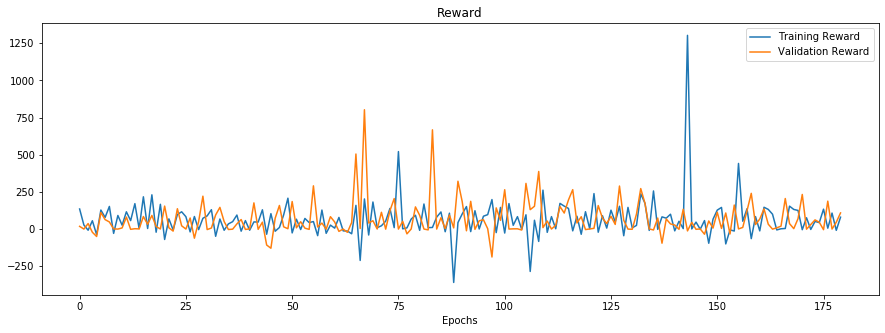

In [44]:
#Training
coloredlogs.install(level='DEBUG')
switch_k_backend_device() #switches to CPU (acc. to author faster than GPU)


if df2_train is not None:
    agent = Agent(window_size*2, pretrained=False, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=False, model_name=model_name)



reslist_t =[] # Train Reward for plotting
reslist_v = [] # Val Reward for plotting


for i in range(1, ep_count + 1): 
    np.random.shuffle(cols1)
    #shuffle columns of training data
    cols = df_train.columns.values
    np.random.shuffle(cols)
    df_train_s = df_train[cols]
    print(df_train_s.head())

    #print(cols)

    for column in df_train_s:
        #create list
        df_train_list = list(df_train_s[column])
        df_val_list = list(df_val[column])

        #dft = df_test.rename(columns={column: 'actual'})
        initial_offset = df_train_list[1] - df_train_list[0]
                
        train_result = train_model(agent, i, df_train_list, df2_train_list, ep_count=ep_count,
                                batch_size=batch_size, window_size=window_size)
        val_result, _ = evaluate_model(agent, df_val_list, df2_val_list, window_size, debug)
        show_train_result(train_result, val_result, initial_offset)
      
        reslist_t.append(train_result[2]) # append reward of training
        reslist_v.append(val_result)
        
# Plotting Training History  
plt.figure(figsize = (15,5))
plt.plot(reslist_t, label = "Training Reward");
plt.plot(reslist_v, label = "Validation Reward");
plt.title("Reward")
plt.xlabel("Epochs")
plt.legend()
plt.show()



## Visualization of actions taken by Trading Bot

In [41]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    #alt.Chart(df.reset_index()).mark_line().encode(x='index')
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df.reset_index()).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='Date:T', #'date:T'
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df.reset_index()).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('Date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="your stock").properties(height=300, width=1000)
    
    return chart

## Plotting the evaluation actions

## Testing the Model
__Select correct model for Testing! (test model not linked to trained model)__

### Load different types of stocks in model:
 - Growth: Adobe (ADBE), Apple (AAPL)
 - Cyclical: Royal Caribbean (RCL)
 - Slow and low dividend: Costco (COST)
 - Turnaround: A&F (ANF)
 - Other: Gold
 
### Load generated data
  - Sin function
  - Random Data
 
 

I1003 17:00:34.841530  8916 connectionpool.py:813] Starting new HTTPS connection (1): finance.yahoo.com:443
2019-10-03 17:00:34 PC-Stefan urllib3.connectionpool[18304] DEBUG Starting new HTTPS connection (1): finance.yahoo.com:443
I1003 17:00:35.258388  8916 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1570154399&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-03 17:00:35 PC-Stefan urllib3.connectionpool[18304] DEBUG https://finance.yahoo.com:443 "GET /quote/ADBE/history?period1=1451617200&period2=1570154399&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
I1003 17:00:35.590475  8916 connectionpool.py:393] https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&period2=1570154399&interval=1d&frequency=1d&filter=history HTTP/1.1" 200 None
2019-10-03 17:00:35 PC-Stefan urllib3.connectionpool[18304] DEBUG https://finance.yahoo.com:443 "GET /quote/AAPL/history?period1=1451617200&perio

<Figure size 432x288 with 0 Axes>

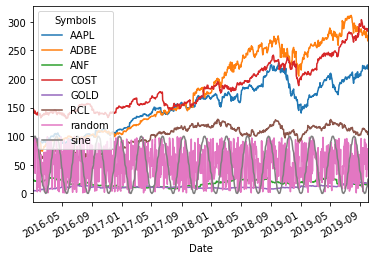

In [10]:
# Loading Test Data
# Setting Start and Enddate for Validation


start_test = datetime.datetime(2016, 1, 1)
end_test = datetime.datetime.now()

# Load Test Data

# Load several stocks
df_test = web.DataReader(['ADBE', 'AAPL', 'RCL', 'COST', 'ANF', 'GOLD'],'yahoo',
                               start=start_test, 
                               end=end_test)['Adj Close']

#Add random column for testing
df_test['random']=np.random.randint(1,100,df_test.shape[0])
df_test['sine']=50+50*np.sin(np.linspace(1,100,df_test.shape[0]))

# define second data input
df2_test = web.DataReader('GOLD','yahoo',
                               start=start_test, end=end_test)

# Convert df2_test to list
df2_test_list = list(df2_test['Adj Close'])


plt.figure();
df_test.plot();


In [45]:
#Load Model
model_name = 'model_w15v2_30'

# Init Model
window_size = 15

# Initialize Agent
if df2_test_list is not None:
    agent = Agent(window_size*2, pretrained=True, model_name=model_name)
else:
    agent = Agent(window_size, pretrained=True, model_name=model_name)

sum = 0
# Loop over stocks
for column in df_test:
    print(column)
    #rename feature column name
    df_test_list = list(df_test[column])
    dft = df_test.rename(columns={column: 'actual'})
    initial_offset = df_test_list[1] - df_test_list[0]
    val_result, history = evaluate_model(agent, df_test_list, df2_test_list, window_size, debug)
    show_eval_result(model_name, val_result, initial_offset)
    chart = visualize(dft, history)
    sum = sum+val_result
    print("Earnings of Model: ", val_result)
    #chart.display()

print("Sum: ", sum)

AAPL


I1003 23:19:57.164391  8916 evaluate.py:111] model_w15v2_30: +$127.97

2019-10-03 23:19:57 PC-Stefan root[18304] INFO model_w15v2_30: +$127.97



Earnings of Model:  127.97403717041016
ADBE


I1003 23:19:57.561728  8916 evaluate.py:111] model_w15v2_30: +$302.70

2019-10-03 23:19:57 PC-Stefan root[18304] INFO model_w15v2_30: +$302.70



Earnings of Model:  302.6998291015625
ANF


I1003 23:19:57.967683  8916 evaluate.py:111] model_w15v2_30: -$8.32

2019-10-03 23:19:57 PC-Stefan root[18304] INFO model_w15v2_30: -$8.32



Earnings of Model:  -8.321293830871582
COST


I1003 23:19:58.369837  8916 evaluate.py:111] model_w15v2_30: +$101.96

2019-10-03 23:19:58 PC-Stefan root[18304] INFO model_w15v2_30: +$101.96



Earnings of Model:  101.96377563476562
GOLD


I1003 23:19:58.761682  8916 evaluate.py:111] model_w15v2_30: -$2.26

2019-10-03 23:19:58 PC-Stefan root[18304] INFO model_w15v2_30: -$2.26



Earnings of Model:  -2.2600584030151367
RCL


I1003 23:19:59.153673  8916 evaluate.py:111] model_w15v2_30: +$56.21

2019-10-03 23:19:59 PC-Stefan root[18304] INFO model_w15v2_30: +$56.21



Earnings of Model:  56.21148681640625
random


I1003 23:19:59.575590  8916 evaluate.py:111] model_w15v2_30: +$9718.00

2019-10-03 23:19:59 PC-Stefan root[18304] INFO model_w15v2_30: +$9718.00



Earnings of Model:  9718
sine


I1003 23:19:59.997946  8916 evaluate.py:111] model_w15v2_30: -$5220.25

2019-10-03 23:19:59 PC-Stefan root[18304] INFO model_w15v2_30: -$5220.25



Earnings of Model:  -5220.246699395459
Sum:  5076.021077093799
